<a href="https://colab.research.google.com/github/Nakamoto618/ResNet_Mahjong_Rank_Prediction/blob/main/ResNet_rank_Alpahzero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Activation, Dense, Dropout, Reshape, Input, Conv2D, BatchNormalization, GlobalAveragePooling2D, Add, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

## データ読み込み

In [2]:
x = np.load('data_monte/data_np_monte.npz')
t = np.load('data_monte/rank_np.npy')

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(x['a'], t, test_size=0.2, random_state=0)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(train_labels[0])

(93678, 4, 9, 392)
(93678, 4)
(23420, 4, 9, 392)
(23420, 4)
[4. 3. 2. 1.]


In [4]:
train_labels = to_categorical(train_labels - 1)
test_labels = to_categorical(test_labels - 1)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(train_labels[0])

(93678, 4, 9, 392)
(93678, 4, 4)
(23420, 4, 9, 392)
(23420, 4, 4)
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [6]:
def conv(filters, kernel_size, strides=1):
  # return Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))
  return Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')

# モデルの定義

## 残差ブロック

In [7]:
#残差ブロックの生成
def residual_unit_50to152(filters):
  def f(x):
    sc = x

    x = conv(filters, 1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = conv(filters, 3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = conv(filters * 4, 1)(x)
    x = BatchNormalization()(x)
    # Activationはここでは適用しない

    # ショートカット接続の調整
    if sc.shape[-1] != x.shape[-1]:
        sc = conv(filters * 4, 1)(sc)
        sc = BatchNormalization()(sc)

    # AddとActivation
    x = Add()([x, sc])
    x = Activation('relu')(x)
    return x
  return f

def residual_unit_18to34(filters):
  def f(x):
    sc = x

    x = conv(filters, 3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = conv(filters, 3)(x)
    x = BatchNormalization()(x)

    # ショートカット接続の調整
    if sc.shape[-1] != x.shape[-1]:
        sc = conv(filters, 1)(sc)
        sc = BatchNormalization()(sc)

    # AddとActivation
    x = Add()([x, sc])
    x = Activation('relu')(x)
    return x
  return f

In [8]:
#残差ブロックの生成
def residual_block_50to152(filters, strides, unit_size):
  def f(x):
    for i in range(unit_size):
      x = residual_unit_50to152(filters)(x)
    return x
  return f

def residual_block_18to34(filters, strides, unit_size):
  def f(x):
    for i in range(unit_size):
      x = residual_unit_18to34(filters)(x)
    return x
  return f

## モデル

In [9]:
#入力データのシェイプ
input = Input(shape=(4, 9, train_data.shape[3]))

x = conv(256, 3, 1)(input)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = residual_block_50to152(64, 1, 3)(x)
x = residual_block_50to152(128, 1, 4)(x)
x = residual_block_50to152(256, 1, 6)(x)
x = residual_block_50to152(512, 1, 3)(x)

# x = residual_block_18to34(64, 1, 3)(x)
# x = residual_block_18to34(128, 1, 4)(x)
# x = residual_block_18to34(256, 1, 6)(x)
# x = residual_block_18to34(512, 1, 3)(x)

x = Flatten()(x)

#全結合層
size_1 = 512
size_2 = 128
size_3 = 64
size_4 = 64

x = Dense(size_1, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dense(size_2, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dense(size_3, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dense(size_4, activation='relu')(x)
# x = BatchNormalization()(x)

#全結合層
x = Dropout(0.5)(x)
x = Dense(16)(x)
x = Reshape((4, 4))(x)
output = Activation('softmax')(x)

#モデルの作成
model = Model(inputs=input, outputs=output)
model.summary()

Model: "functional"

 Total params: 62,210,064 (237.31 MB)

 Trainable params: 62,156,048 (237.11 MB)

 Non-trainable params: 54,016 (211.00 KB)

## データの拡張

# モデルの学習

In [10]:
#LearningRateSchedulerの準備
def step_decay(epoch):
  x = 1.0e-6
  if epoch >= 50: x = 1.0e-7
  if epoch >= 100: x = 1.0e-8
  if epoch >= 130: x = 1.0e-9
  return x
lr_decay = LearningRateScheduler(step_decay)

from tensorflow.keras.callbacks import ModelCheckpoint

# モデルを保存するためのコールバック
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/AI/着順予測/モデル/best_model_rank.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

import keras
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [11]:
import tensorflow as tf
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['acc', tf.keras.metrics.AUC(name='auc')]
)

## 学習ループ

In [12]:
from typing import Text
from keras.callbacks import TensorBoard

batch_size = 128

history = model.fit(
    x=train_data,
    y=train_labels,
    batch_size=batch_size,
    epochs=150,
    validation_split=0.2,
    callbacks=[lr_decay, checkpoint, callback]
)

Epoch 1/150
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.2568 - auc: 0.5089 - loss: 2.2971
Epoch 1: val_loss improved from inf to 1.68895, saving model to /content/drive/MyDrive/AI/着順予測/モデル/best_model_rank.keras
586/586 ━━━━━━━━━━━━━━━━━━━━ 110s 106ms/step - acc: 0.2568 - auc: 0.5089 - loss: 2.2969 - val_acc: 0.2878 - val_auc: 0.5410 - val_loss: 1.6890 - learning_rate: 1.0000e-06
Epoch 2/150
585/586 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.2789 - auc: 0.5336 - loss: 2.0146
Epoch 2: val_loss improved from 1.68895 to 1.57591, saving model to /content/drive/MyDrive/AI/着順予測/モデル/best_model_rank.keras
586/586 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - acc: 0.2790 - auc: 0.5336 - loss: 2.0144 - val_acc: 0.3099 - val_auc: 0.5665 - val_loss: 1.5759 - learning_rate: 1.0000e-06
Epoch 3/150
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.2951 - auc: 0.5503 - loss: 1.8482
Epoch 3: val_loss improved from 1.57591 to 1.46273, saving model to /content/drive/MyDrive/AI/着順予測/モデル/best_model_rank.k

In [13]:
model.save('/ResNet_rank_model.keras')

# モデルの評価

## グラフ

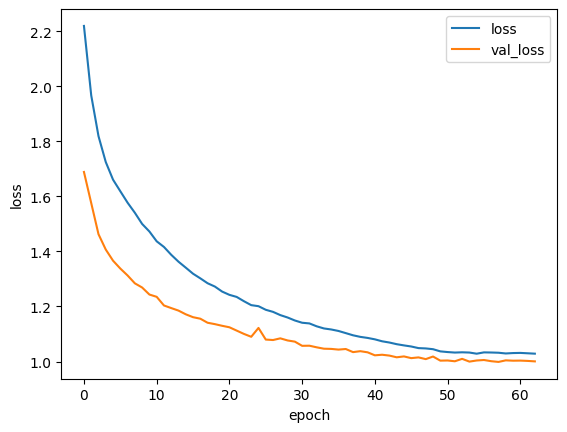

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

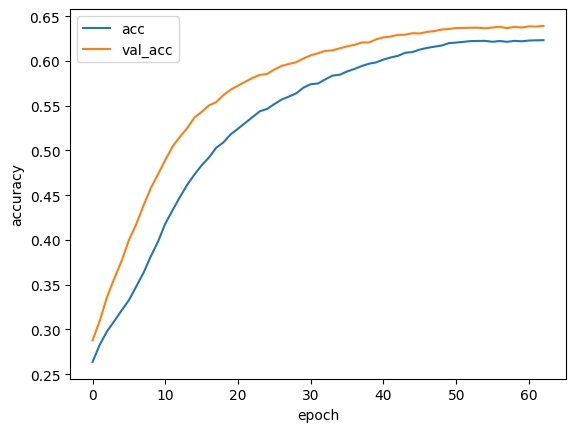

In [15]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

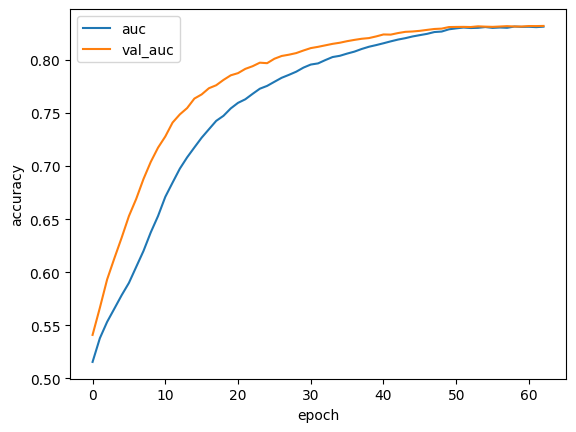

In [16]:
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [17]:
import keras
import os
model = keras.models.load_model('/best_model_rank.keras')


## 推論

732/732 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
(93680,)
(93680,)
Confusion Matrix:


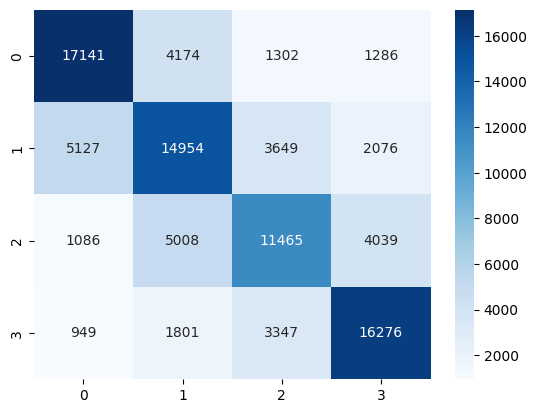

Accuracy: 0.638727583262169
F1 Score: 0.6373150176796641


In [18]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve, auc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# モデルで予測を実行
y_pred = model.predict(test_data)

# 予測結果をラベルに変換（各サンプルの最も高いスコアを持つクラスラベルを取得）
y_pred_classes = np.argmax(y_pred, axis=2).reshape(-1)

# テストラベルをラベルに変換（各サンプルの正解クラスラベルを取得）
y_true = np.argmax(test_labels, axis=2).reshape(-1)

# y_trueとy_pred_classesの形状を確認
print(y_true.shape)
print(y_pred_classes.shape)

# 混同行列の計算とプロット
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

# 正答率の計算
accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy:", accuracy)

# F1スコアの計算
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print('F1 Score:', f1)

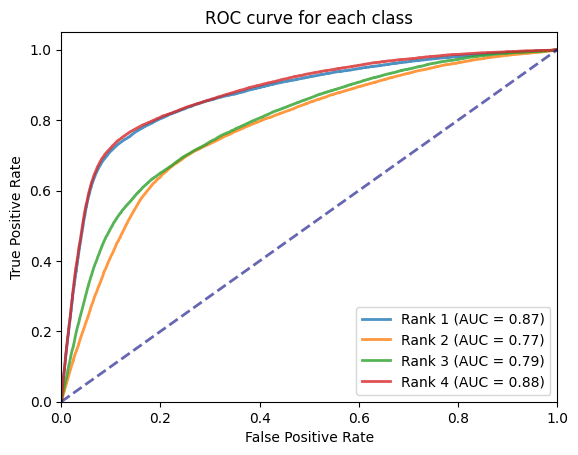

roc_auc_score for different averaging methods:
	macro: 0.83
	micro: 0.83
	weighted: 0.83
	None: [0.8705974193289971, 0.7748822966278328, 0.7924586903178626, 0.8768421563240053]
	Average of None: 0.83


In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# ROC曲線とAUCの計算とプロット
n_classes = y_pred.shape[2]  # クラス数の取得

# y_trueをone-hotエンコードに変換
y_true_one_hot = np.eye(n_classes)[y_true.reshape(-1)]

# y_predを2次元に変換
y_pred_2d = y_pred.reshape(-1, n_classes)

# ROC曲線のプロット
roc_auc_scores = []

for i in range(n_classes):
    # クラスiに対するROC曲線とAUCを計算
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_2d[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.8, label=f'Rank {i+1} (AUC = {roc_auc:.2f})')

# 対角線をプロット
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.6)

# プロットの設定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each class')
plt.legend(loc="lower right")
plt.show()

# 各種平均方法でのROC AUCスコアの計算
print("roc_auc_score for different averaging methods:")

# macro, micro, weightedを手動で計算
roc_auc_macro = np.mean(roc_auc_scores)
roc_auc_micro = roc_auc_score(y_true_one_hot, y_pred_2d, average='micro')
roc_auc_weighted = np.average(roc_auc_scores, weights=np.sum(y_true_one_hot, axis=0))

print("\tmacro: {:.2f}".format(roc_auc_macro))
print("\tmicro: {:.2f}".format(roc_auc_micro))
print("\tweighted: {:.2f}".format(roc_auc_weighted))

# average=Noneの場合のAUCスコアの表示
print("\tNone: {}".format(roc_auc_scores))
print("\tAverage of None: {:.2f}".format(np.mean(roc_auc_scores)))

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71     23903
           1       0.58      0.58      0.58     25806
           2       0.58      0.53      0.55     21598
           3       0.69      0.73      0.71     22373

    accuracy                           0.64     93680
   macro avg       0.64      0.64      0.64     93680
weighted avg       0.64      0.64      0.64     93680

